In [2]:
import pandas as pd
import numpy as np
import re
import itertools
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

import spacy
from spacy.matcher import PhraseMatcher
from spacy.pipeline import EntityRecognizer

from skillNer.general_params import SKILL_DB
from skillNer.skill_extractor_class import SkillExtractor

from gensim.utils import simple_preprocess

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('german') + stopwords.words('english'))

nlp = spacy.load("en_core_web_lg") 


[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_json("./data/DS_crawl.json", lines = True)
df

,headline,stadt,links,text
0,Senior Data Science Consultant (w/m/d),Weinheim,https://www.stepstone.de/stellenangebote--Seni...,Freudenberg ist ein globales Technologieuntern...
1,Data Science and Engineering Manager - Machine...,Berlin,https://www.stepstone.de/stellenangebote--Data...,"At Trade Republic, we are on a mission to demo..."
2,Praktikant Media & Marketing Analytics - Data ...,Köln,https://www.stepstone.de/stellenangebote--Prak...,"Ort: 51063 Köln | Vertragsart: Vollzeit, befri..."
3,Data Science & Artificial Intelligence Manager...,München,https://www.stepstone.de/stellenangebote--Data...,Design von Data Science und AI-Services im Ber...
4,Manager Data Science & Machine Learning - Data...,"Berlin, Düsseldorf, Frankfurt/Main, Hamburg, M...",https://www.stepstone.de/stellenangebote--Mana...,"Bei EY setzen wir alles daran, dass die Welt b..."
...,...,...,...,...
5395,"Leitung der Abteilung Abfallbewirtschaftung, B...",Gifhorn,https://www.stepstone.de/stellenangebote--Leit...,Der Landkreis Gifhorn ist mit ca. 900 Mitarbei...
5396,Prozessexperte (w/m/d) für die biotechnologisc...,Halle,https://www.stepstone.de/stellenangebote--Proz...,Unsere Welt braucht Ideen! Als eines der forsc...
5397,(Senior) Test Automation Engineer for medical ...,"München,",https://www.stepstone.de/stellenangebote--Seni...,"Step out of your comfort zone, excel and redef..."
5398,Configuration Engineer (m/w/d),"Sailauf, München",https://www.stepstone.de/stellenangebote--Conf...,Job Number: 39977\nGroup: Magna Electronics...


In [3]:
def get_skills(text:str, skill_extractor, index:int) -> list:
    '''
    Extract Skills with Spacy and SkillNer
    '''
    if index%100==0:
        print(f"Process Text at Index {index}")
    try:
        annotations = skill_extractor.annotate(text)
        return list(set([j.get("doc_node_value") for j in annotations["results"].get("ngram_scored")]))
    except:
        return [""]
    

skill_extractor = SkillExtractor(nlp, SKILL_DB, PhraseMatcher)
final_txt_list = [" ".join([word for word in simple_preprocess(str(doc)) if word not in stop_words]) for doc in df["text"]]

with ThreadPoolExecutor(max_workers=min(50, len(final_txt_list))) as pool:
    results = pool.map(get_skills, final_txt_list, [skill_extractor for _ in range(len(final_txt_list))], [i for i in range(len(final_txt_list))])


df["skills"] = [i for i in results]

loading full_matcher ...
loading abv_matcher ...
loading full_uni_matcher ...
loading low_form_matcher ...
loading token_matcher ...
Process Text at Index 0


/usr/local/lib/python3.10/site-packages/skillNer/utils.py:99: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  vec_similarity = token1.similarity(token2)


Process Text at Index 100
Process Text at Index 200
Process Text at Index 300
Process Text at Index 400
Process Text at Index 500
Process Text at Index 600
Process Text at Index 700
Process Text at Index 800
Process Text at Index 900
Process Text at Index 1000
Process Text at Index 1100
Process Text at Index 1200
Process Text at Index 1300
Process Text at Index 1400
Process Text at Index 1500
Process Text at Index 1600
Process Text at Index 1700
Process Text at Index 1800
Process Text at Index 1900
Process Text at Index 2000
Process Text at Index 2100
Process Text at Index 2200
Process Text at Index 2300
Process Text at Index 2400
Process Text at Index 2500
Process Text at Index 2600
Process Text at Index 2700
Process Text at Index 2800
Process Text at Index 2900
Process Text at Index 3000
Process Text at Index 3100
Process Text at Index 3200
Process Text at Index 3300
Process Text at Index 3400
Process Text at Index 3500
Process Text at Index 3600
Process Text at Index 3700
Process Te

München              1048
Berlin                913
Hamburg               817
Stuttgart             647
Köln                  504
Frankfurt am Main     471
Düsseldorf            381
Essen                 134
Hannover              127
Frankfurt             124
dtype: int64


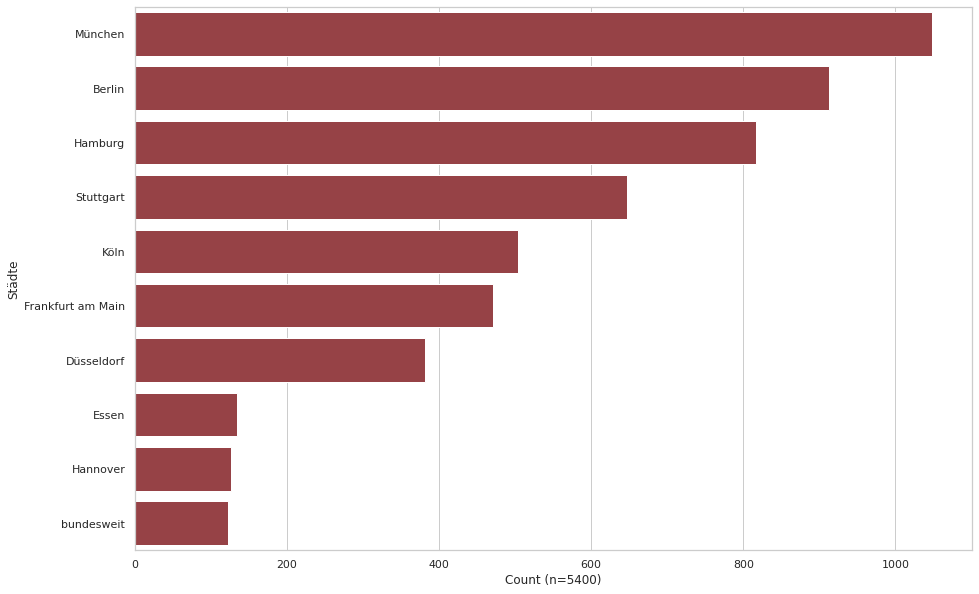

In [16]:
cities = list(itertools.chain(*[i.split(",") for i in df["stadt"]]))
cities = [i.strip() for i in cities]
cities = [city.replace('Frankfurt (Main)', "Frankfurt am Main").replace('Frankfurt/Main', "Frankfurt am Main").replace('Frankfurt a. M.', "Frankfurt am Main") for city in cities if len(city) != 0] 

#First check top cities
print(pd.Series(cities).value_counts()[:10])

top_cities = ['München', 'Berlin', 'Hamburg', 'Stuttgart', 'Köln',
       'Frankfurt am Main', 'Düsseldorf', 'Essen', 'Hannover',
       'bundesweit']

top_cities_data = [city for city in cities if city in [i for i in top_cities]]

sns.set(rc = {'figure.figsize':(15,10)}, style='whitegrid')
palette=["#A4343A"]

ax = sns.countplot(y="class", data=pd.DataFrame({"class": top_cities_data}), 
            order = pd.Series(top_cities).value_counts().index, palette=palette)
ax.set(xlabel = f"Count (n={len(df)})", ylabel='Städte')
plt.show()


In [4]:
#Top10 Skills
skills = list(itertools.chain(*df["skills"]))

#Add Excel and R, because they are missing in the used skill DB
skills = skills + list(itertools.chain(*([list(set(re.findall("\\bR\\b", i))) for i in df["text"] if list(set(re.findall("\\bR\\b", i)))])))
skills = skills + list(itertools.chain(*([list(set(re.findall("\\bExcel\\b", i))) for i in df["text"] if list(set(re.findall("\\bExcel\\b", i)))])))

#Check for relevant Skills first
print((pd.Series(skills).value_counts())[:20])

tech_stack = ["stata","excel","Python", "R", "sql", "java", "big data", "devops", "docker", "git", "kubernetes", "machine learning", "linux", "javascript", "algorithms", "terraform", "spss", "nosql", "deep learning"]
skill_set = ["agile","innovative", "english", "german", "communication skills", "creative", "analytical", "scrum", "programming", "teamwork", "enthusiasm", "reliability"] 
benefits = ["childcare", "yoga", "food", "personal development"]

tech_stack = ["stata","excel","Python", "R", "sql", "java", "docker", "git", "kubernetes", "machine learning", "linux", "javascript", "terraform", "spss", "deep learning"]
skill_set = ["agile","innovative", "communication skills", "creative", "analytical", "scrum", "programming", "teamwork", "enthusiasm", "reliability"] 


english                 1342
www                     1341
innovative              1262
german                  1142
python                  1138
analytics               1010
management               917
agile                    801
sql                      774
innovation               721
digitale                 719
mobility                 603
R                        590
social                   588
transformation           575
communication skills     568
plan                     566
integration              505
creative                 494
Excel                    488
dtype: int64


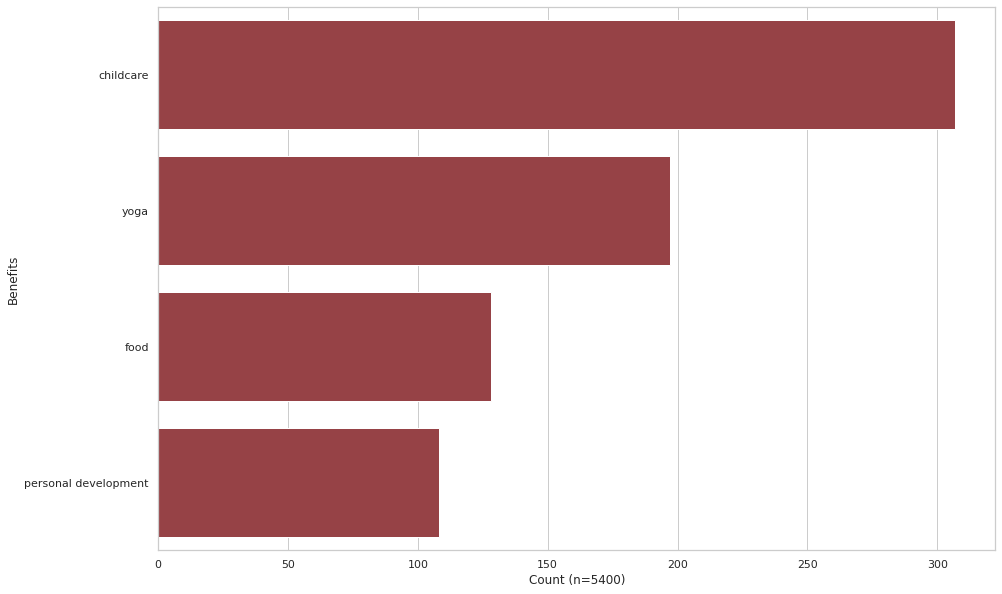

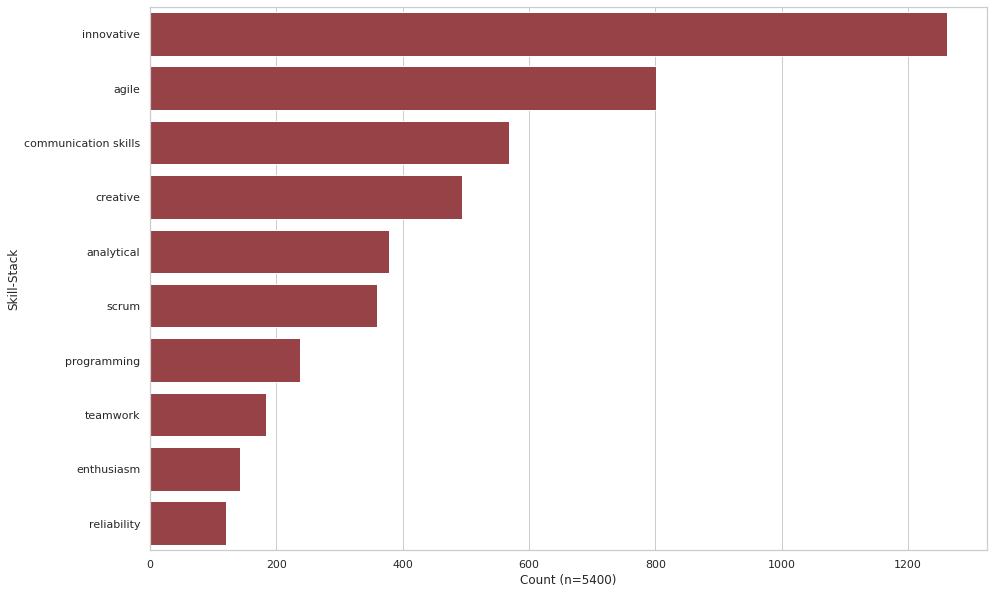

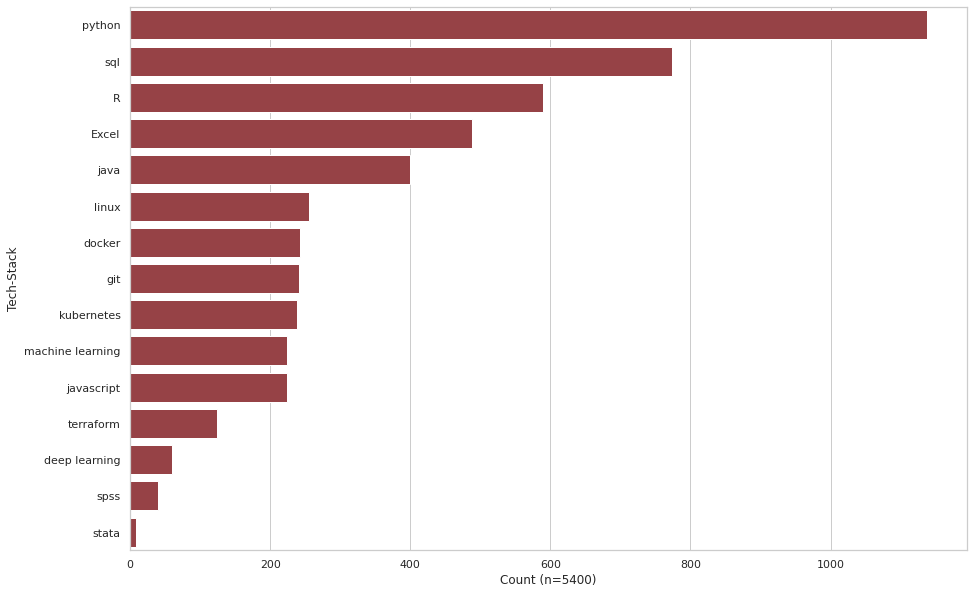

In [15]:
sns.set(rc = {'figure.figsize':(15,10)}, style='whitegrid')
palette=["#A4343A"]


benefits_data = [skill for skill in skills if skill.lower() in [i.lower() for i in benefits]]
ax = sns.countplot(y="class", data=pd.DataFrame({"class": benefits_data}), 
            order = pd.Series(benefits_data).value_counts().index, palette=palette)
ax.set(xlabel=f"Count (n={len(df)})", ylabel='Benefits')
plt.show()

skill_set_data = [skill for skill in skills if skill.lower() in [i.lower() for i in skill_set]]
ax = sns.countplot(y="class", data=pd.DataFrame({"class": skill_set_data}), 
            order = pd.Series(skill_set_data).value_counts().index, palette=palette)
ax.set(xlabel=f"Count (n={len(df)})", ylabel='Skill-Stack')

plt.show()

tech_stack_data = [skill for skill in skills if skill.lower() in [i.lower() for i in tech_stack]]
ax = sns.countplot(y="class", data=pd.DataFrame({"class": tech_stack_data}), 
            order = pd.Series(tech_stack_data).value_counts().index, palette=palette)
ax.set(xlabel = f"Count (n={len(df)})", ylabel='Tech-Stack')

plt.show()
